# Where does my CNN look at?
In this notebook, we will visualize the feature maps of a convolutional neural network (CNN) to understand what parts of the image are being focused on by the model. We will use a pre-trained ResNet model from PyTorch's torchvision library and visualize the feature maps of the last convolutional layer. We will also use Grad-CAM to visualize

We  <span style="color:red">do not</span> expect you to understand everything in this notebook. The goal is to learn how to loas a pre-trained model, apply transforms, and visualize the feature maps.

<span style="color:red"> Important</span>: Use a cat image to test the code. You can use other images too, but results may not come in favor (this is becuase we restricted the model to only 2 classes).

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import  torchvision.transforms as transforms
from PIL import Image
import cv2
from transformers import ResNetForImageClassification
import matplotlib.pyplot as plt

In [ ]:
#TODO  Load pretrained resnet model
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

#TODO  Define transforms to preprocess input image into format expected by model
# use mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225] for normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

#TODO  Inverse transform to get normalize image back to original form for visualization
inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

#TODO  Transforms to resize image to the size expected by pretrained model(224, 224), convert PIL image to tensor, and normalize the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Load your image

In [4]:
#TODO
readImg = "cat.jpg"
img0 = Image.open(readImg).convert('RGB')

## CAM
the class activation map (CAM) for a specific class in the image. This will help us understand which parts of the image are important for the model's prediction.
There are some advanced functions in the code that are not necessary for you to understand the basic concepts of feature map visualization and Grad-CAM. However, I will explain them briefly in the comments. You can ignore them if you are not interested in the details.

In [5]:
# This code defines a callback function for PyTorch hooks
# It creates a dictionary to store activations from network layers
# getActivation returns a hook function that saves the output of a specific layer
# when that layer is executed during forward pass
activation = {}
def getActivation(name):
    def hook(module, input, output):
        activation[name] = output.detach().cpu().numpy()
    return hook

In [6]:
# Register a hook to capture the outputs of the last stage of the ResNet model
# This hook will store the activations in our 'activation' dictionary with key 'last_stage'
# These activations will be used later to generate the Class Activation Map (CAM)
model.resnet.encoder.stages[-1].register_forward_hook(getActivation('last_stage'))

In [7]:
params = list(model.classifier[1].parameters())
weight = np.squeeze(params[0].data.numpy())

In [8]:
# This function generates Class Activation Maps (CAM) for specified classes
# It uses the feature maps from the convolutional layer and the weights from the classifier
# to create a heatmap showing which parts of the image are most important for classification
# Params:
#   feature_conv: features from the last convolutional layer
#   weight: weights from the classifier layer for each class
#   class_idx: indices of classes to generate CAMs for
# Returns:
#   List of upsampled CAM heatmaps (one per requested class)

def return_CAM(feature_conv, weight, class_idx):
    # generate the class -activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        beforeDot =  feature_conv.reshape((nc, h*w))
        cam = np.matmul(weight[idx], beforeDot)
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam

In [9]:
model.eval()
logit = model(transform(img0).unsqueeze(0)).logits

In [10]:
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()

In [11]:
CAMs = return_CAM(activation['last_stage'], weight, [idx[0]])

In [12]:
img = cv2.imread(readImg)
height, width, _ = img.shape
heatmap = cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET)
result = heatmap * 0.5 + img * 0.5

cv2.imwrite("image_1.jpg", result)

True

In [13]:
model.config.id2label[idx[0]]

'tabby, tabby cat'

# Grad-CAM

Grad-CAM is a technique that uses the gradients of the target class with respect to the feature maps of the last convolutional layer to create a heatmap that highlights the important regions in the image. It helps us understand which parts of the image are contributing to the model's prediction for a specific class. Again, you do not need to worry about the details of Grad-CAM for now. Just know that it is a powerful technique for visualizing the important regions in an image for a specific class.

In [14]:
# Define global dictionaries to store gradients and activations from the network
# getGradients returns a hook function that captures the gradients during backward pass
# getActivations returns a hook function that captures the activations during forward pass
# These hooks will be registered to specific layers to extract information for Grad-CAM visualization
gradients = {}
activations = {}

def getGradients(name):
    def backward_hook(module, grad_input, grad_output):
        gradients[name] = grad_output
    return backward_hook

def getActivations(name):
    def forward_hook(module, args, output):
        activations[name] = output
    return forward_hook

In [15]:
backward_hook = model.resnet.encoder.stages[-1].layers[-1].register_backward_hook(getGradients('lastLayer'))
forward_hook = model.resnet.encoder.stages[-1].layers[-1].register_forward_hook(getActivations('lastLayer'))

In [16]:
model.eval()
logit = model(transform(img0).unsqueeze(0)).logits
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.detach().numpy()
idx = idx.numpy()
model.config.id2label[idx[0]]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


'tabby, tabby cat'

In [17]:
logit[0,idx[0]].backward()

In [18]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients['lastLayer'][0], dim=[0, 2, 3])

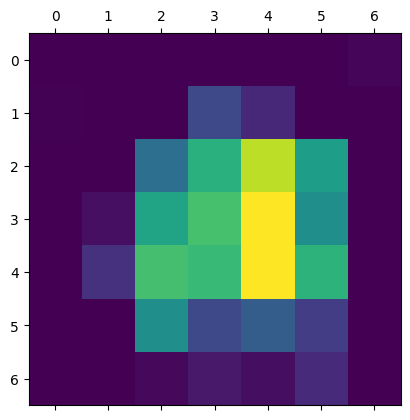

In [19]:
# weight the channels by corresponding gradients
for i in range(activations['lastLayer'].size()[1]):
    activations['lastLayer'][:, i, :, :] *= pooled_gradients[i]

# average the channels of the activations
heatmap = torch.mean(activations['lastLayer'], dim=1).squeeze()

# relu on top of the heatmap
heatmap = F.relu(heatmap).detach().cpu().numpy()

#TODO normalize the heatmap
heatmap = np.maximum(heatmap, 0)
heatmap = heatmap / np.max(heatmap)

#TODO draw the heatmap
plt.matshow(heatmap)
plt.show()

In [20]:
#TODO  load the image by cv2
img = cv2.imread(readImg)
height, width, _ = img.shape
#TODO Resize and apply color map to the heatmap
heatmap_resized = cv2.resize(heatmap, (width, height))
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)

#TODO  Add the heatmap to the original image
result = heatmap_colored * 0.4 + img * 0.6
cv2.imwrite("image_1.jpg", result)

True

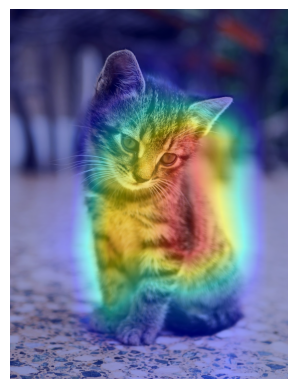

In [21]:
# Convert result to uint8 before color conversion
result_uint8 = result.astype(np.uint8)
plt.imshow(cv2.cvtColor(result_uint8, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
